In [63]:
import pandas as pd 
import ast 
api_results_xls = pd.ExcelFile('api_retrieved.xlsx')
api_results_dct = {} 
for sheet in api_results_xls.sheet_names: 
    api_results_dct[sheet] = pd.read_excel('api_retrieved.xlsx', sheet_name = sheet)
oa_results_df_undupe = api_results_dct['api_results_oa']
oa_results_df = oa_results_df_undupe.drop_duplicates(subset = ['api_id_retrieved'])
oa_results_df['topics'] = oa_results_df_undupe['topics'].apply(lambda x : ast.literal_eval(x) if pd.notna(x) else x )

<positron-console-cell-63>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [64]:
oa_results_df['topic_ids'] = oa_results_df['topics'].apply(lambda x: [d['id'] for d in x] if isinstance(x, list) else None)
flattened_data = [
    {'original_index': idx, 'topic_id': item} 
    for idx, sublist in oa_results_df['topic_ids'].items() 
    if isinstance(sublist, list)
    for item in sublist
]

# Step 2: Convert to a DataFrame
flattened_df = pd.DataFrame(flattened_data)

# Group by 'topic_id' and count the number of unique indices
topic_id_coverage = flattened_df.groupby('topic_id')['original_index'].nunique().reset_index()
topic_id_coverage.columns = ['topic_id', 'unique_index_count']
# Calculate the total number of unique indices in the original dataset
total_unique_indices = oa_results_df.index.nunique()

# Calculate the percentage coverage for each topic_id
topic_id_coverage['percentage_coverage'] = (topic_id_coverage['unique_index_count'] / total_unique_indices) * 100
topic_id_coverage_sorted = topic_id_coverage.sort_values(by='percentage_coverage', ascending = False)

<positron-console-cell-64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [65]:
# Group the DataFrame by topic_id and collect the indices for each topic_id
topic_id_to_indices = flattened_df.groupby('topic_id')['original_index'].apply(set).to_dict()

# Initialize a set of all observation indices
all_observations = set(flattened_df['original_index'].unique())

# Initialize an empty set for covered observations and a list to store the selected topic_ids
covered_observations = set()
selected_topic_ids = []

while covered_observations != all_observations:
    # Check if there are any topic_ids left to consider
    if not topic_id_to_indices:
        print("No more topic_ids left to select from.")
        break
    
    # Find the topic_id that covers the most uncovered observations
    best_topic_id = max(topic_id_to_indices, key=lambda k: len(topic_id_to_indices[k] - covered_observations))
    
    # Add this topic_id to the selected list
    selected_topic_ids.append(best_topic_id)
    
    # Update the covered observations
    covered_observations.update(topic_id_to_indices[best_topic_id])
    
    # Remove the selected topic_id from consideration
    del topic_id_to_indices[best_topic_id]

if covered_observations == all_observations:
    print("Selected topic IDs to cover all observations:", selected_topic_ids)
else:
    print("Not all observations could be covered. Selected topic IDs so far:", selected_topic_ids)


Selected topic IDs to cover all observations: ['https://openalex.org/T10390', 'https://openalex.org/T10668', 'https://openalex.org/T10234', 'https://openalex.org/T10263', 'https://openalex.org/T10290', 'https://openalex.org/T10351', 'https://openalex.org/T11629', 'https://openalex.org/T10401', 'https://openalex.org/T11144', 'https://openalex.org/T13430', 'https://openalex.org/T10010', 'https://openalex.org/T10106', 'https://openalex.org/T10196', 'https://openalex.org/T10316', 'https://openalex.org/T10327', 'https://openalex.org/T10364', 'https://openalex.org/T10387', 'https://openalex.org/T10397', 'https://openalex.org/T10459', 'https://openalex.org/T10489', 'https://openalex.org/T10499', 'https://openalex.org/T10686', 'https://openalex.org/T10727', 'https://openalex.org/T10731', 'https://openalex.org/T11167', 'https://openalex.org/T11589', 'https://openalex.org/T11888', 'https://openalex.org/T14313']
Selected topic IDs to cover all observations: ['https://openalex.org/T10390', 'https:

In [66]:
print('Number of topic ids', len(flattened_df['topic_id'].unique()))
print('Number of final chosen topic ids for maximal coverage', len(set(selected_topic_ids)))

Number of topic ids 146
Number of final chosen topic ids for maximal coverage 28
Number of topic ids 146
Number of final chosen topic ids for maximal coverage 28


<positron-console-cell-72>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\dkraj2\Miniconda3\envs\pcosdataset\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\dkraj2\Miniconda3\envs\pcosdataset\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

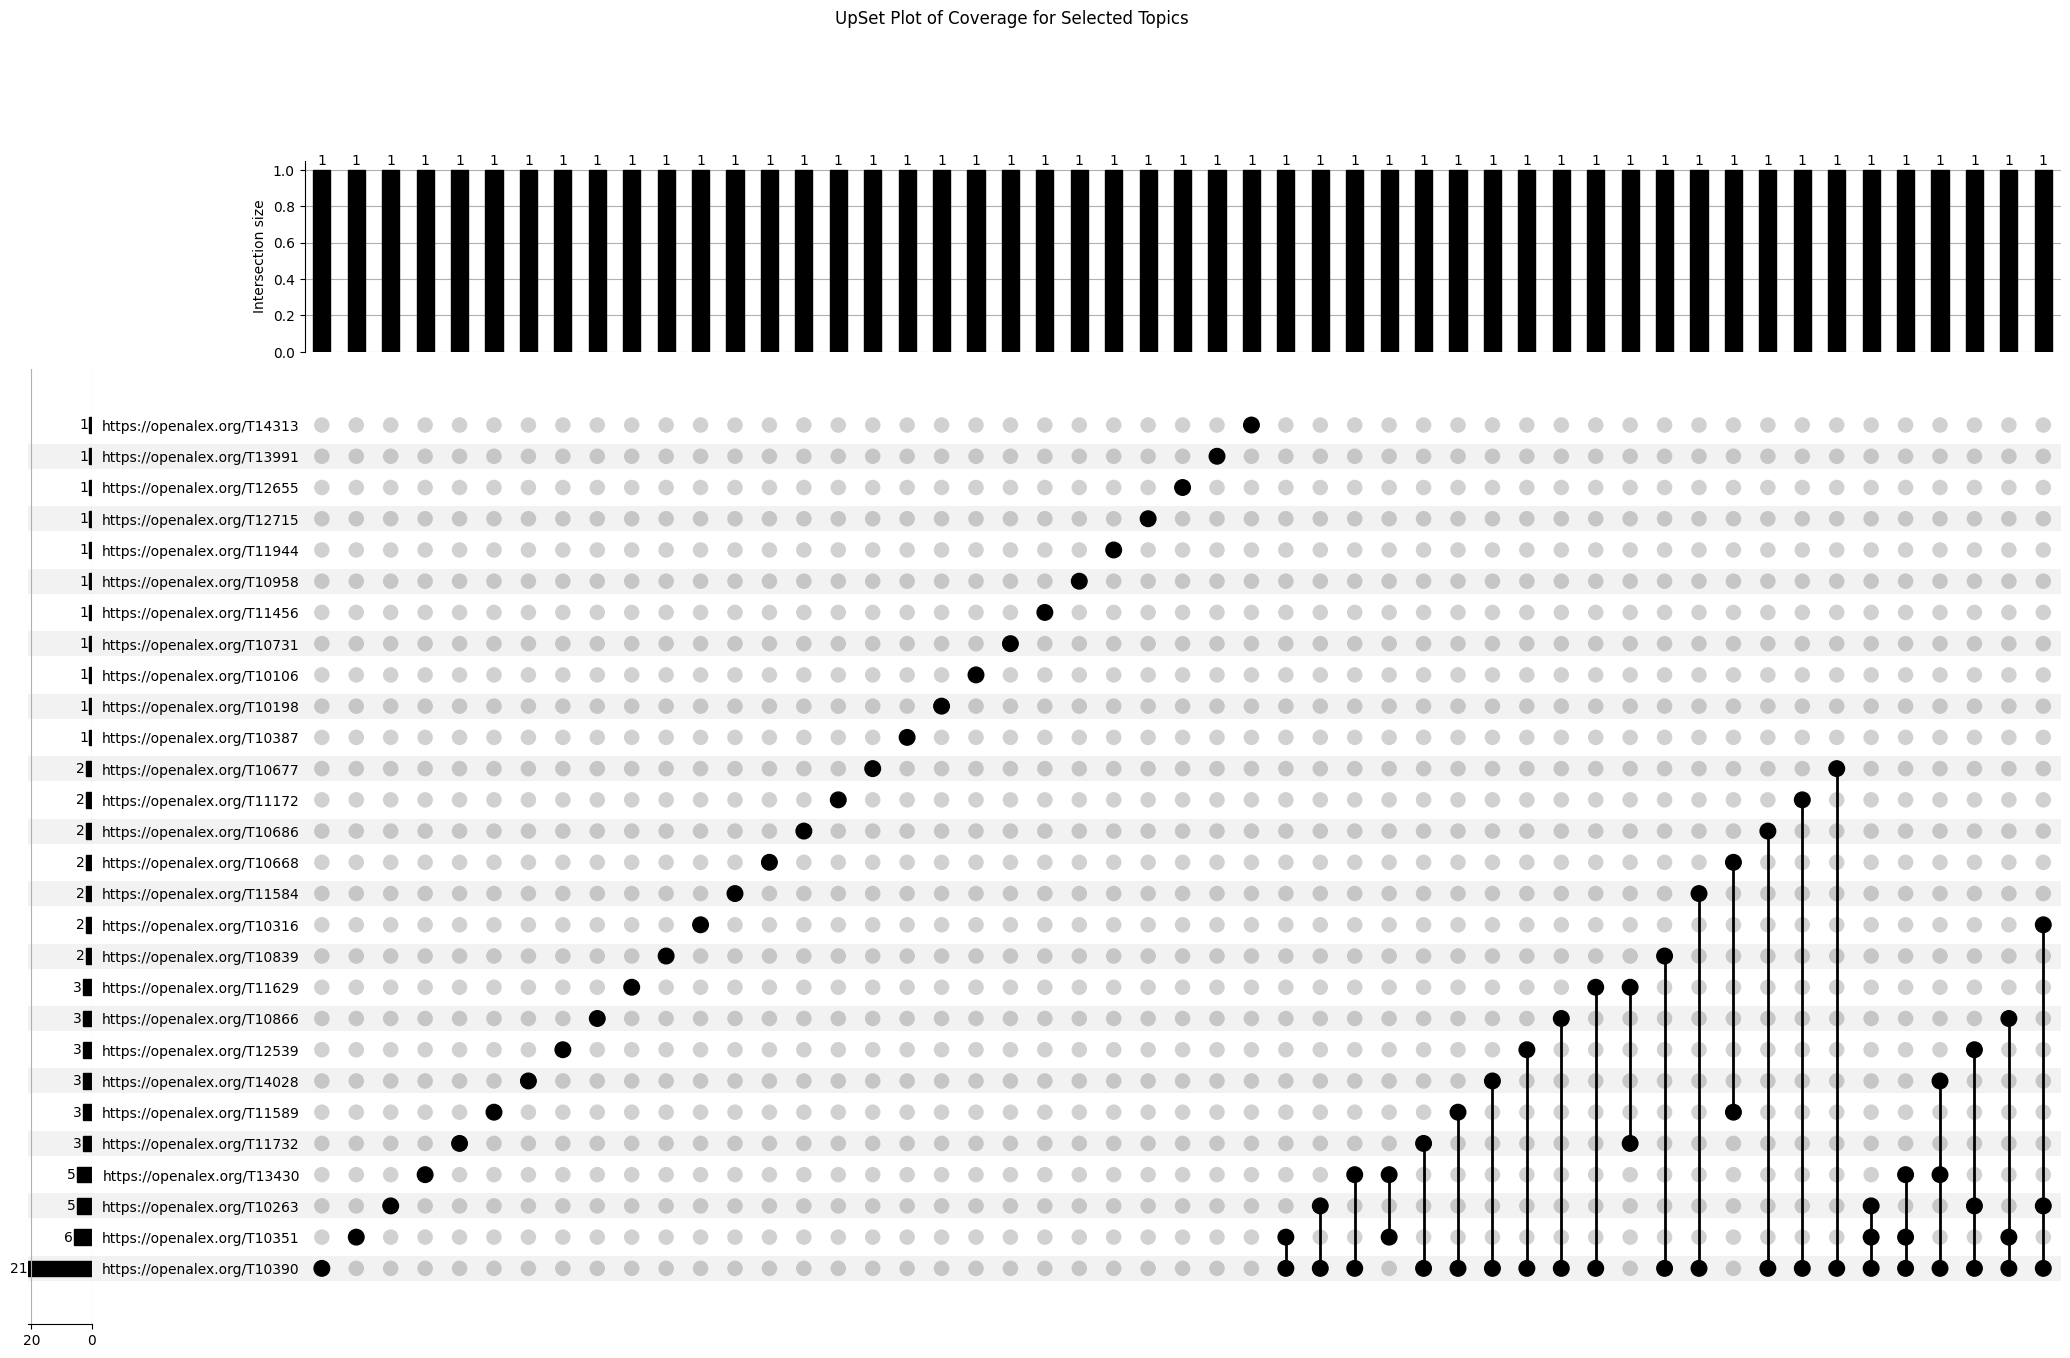

                       topic_id  covered_observations_count  percentage_coverage
6   https://openalex.org/T10390                         941            93.912176
19  https://openalex.org/T11732                         104            10.379242
24  https://openalex.org/T13430                          81             8.083832
2   https://openalex.org/T10263                          55             5.489022
18  https://openalex.org/T11629                          20             1.996008
17  https://openalex.org/T11589                          18             1.796407
21  https://openalex.org/T12539                          18             1.796407
4   https://openalex.org/T10351                          16             1.596806
7   https://openalex.org/T10668                          11             1.097804
3   https://openalex.org/T10316                           8             0.798403
26  https://openalex.org/T14028                           8             0.798403
12  https://openalex.org/T10

In [72]:
import pandas as pd
import pulp
from upsetplot import UpSet
import matplotlib.pyplot as plt

# Step 1: Prepare the data and solve the set cover problem
oa_results_df['topic_ids'] = oa_results_df['topics'].apply(lambda x: [d['id'] for d in x] if isinstance(x, list) else None)

flattened_data = [
    {'original_index': idx, 'topic_id': item} 
    for idx, sublist in oa_results_df['topic_ids'].items() 
    if isinstance(sublist, list)
    for item in sublist
]

# Convert to a DataFrame
flattened_df = pd.DataFrame(flattened_data)

# Group by topic_id and collect the indices for each topic_id
topic_id_to_indices = flattened_df.groupby('topic_id')['original_index'].apply(set).to_dict()

# Solve the set cover problem using PuLP
topic_ids = list(topic_id_to_indices.keys())
observations = set(flattened_df['original_index'].unique())

# Create a binary variable for each topic_id indicating whether it is selected or not
topic_vars = pulp.LpVariable.dicts("Topic", topic_ids, 0, 1, pulp.LpBinary)

# Initialize the problem
problem = pulp.LpProblem("SetCoverProblem", pulp.LpMinimize)

# Objective function: Minimize the total number of selected topic_ids
problem += pulp.lpSum([topic_vars[topic] for topic in topic_ids])

# Constraints: Ensure that each observation is covered by at least one selected topic_id
for obs in observations:
    relevant_topics = [topic for topic, indices in topic_id_to_indices.items() if obs in indices]
    problem += pulp.lpSum([topic_vars[topic] for topic in relevant_topics]) >= 1

# Solve the problem
problem.solve()

# Gather the initial selected topic_ids
selected_topic_ids = [topic for topic in topic_ids if pulp.value(topic_vars[topic]) == 1]

# Post-process to minimize overlap
final_selected_topics = selected_topic_ids.copy()
for topic_id in selected_topic_ids:
    temp_selected_topics = [t for t in final_selected_topics if t != topic_id]
    remaining_coverage = set()
    for t in temp_selected_topics:
        remaining_coverage.update(topic_id_to_indices[t])
    
    if remaining_coverage == observations:
        final_selected_topics.remove(topic_id)

# Step 4: Prepare data for UpSet plot
# Create a DataFrame that tracks the membership of each observation in the selected topics
data = {topic_id: [1 if i in topic_id_to_indices[topic_id] else 0 for i in observations] for topic_id in final_selected_topics}

# Convert to a DataFrame for the UpSet plot
df = pd.DataFrame(data, index=list(observations))

# Generate counts of intersections
intersections = df.groupby(list(final_selected_topics)).size()

# Create an UpSet plot
upset = UpSet(intersections, subset_size='count', show_counts=True, sort_by='degree')
upset.plot()
plt.suptitle('UpSet Plot of Coverage for Selected Topics')
plt.show()

# Optional: Step 5: Create and print the DataFrame summarizing coverage
coverage_data = []
total_observations = len(observations)  # Total unique observations
for topic_id in final_selected_topics:
    covered_count = len(topic_id_to_indices[topic_id])
    percentage_coverage = (covered_count / total_observations) * 100
    coverage_data.append({
        'topic_id': topic_id,
        'covered_observations_count': covered_count,
        'percentage_coverage': percentage_coverage
    })

coverage_df = pd.DataFrame(coverage_data)
coverage_df = coverage_df.sort_values(by='covered_observations_count', ascending=False)
print(coverage_df)


In [69]:
len(final_selected_topics)

28